# Plot ACCESS-OM3 SST bias

https://github.com/COSIMA/cosima-recipes/blob/main/Tutorials/Model_Agnostic_Analysis.ipynb

In [2]:
%matplotlib inline
import pandas as pd
import intake
import dask
import xarray as xr
import numpy as np
import cf_xarray as cfxr
import pint_xarray
from pint import application_registry as ureg
import cf_xarray.units
import cftime
import xgcm
import os

import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

from dask.distributed import Client

In [3]:
xr.set_options(keep_attrs=True); # cf_xarray works best when xarray keeps attributes by default

In [4]:
# from https://github.com/COSIMA/cosima-recipes/blob/main/Tutorials/ACCESS-NRI_Intake_Catalog.ipynb
# Try passing the following argument to your to_dask or to_dataset_dict call:
# See the xarray documentation on Reading multi-file datasets for more details about these arguments.
# https://docs.xarray.dev/en/stable/user-guide/io.html#reading-multi-file-datasets

xarray_combine_by_coords_kwargs=dict(
    compat="override",
    data_vars="minimal",
    coords="minimal"
)

In [5]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41773,Workers: 14
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:45331,Total threads: 1
Dashboard: /proxy/34141/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:38449,


In [6]:
thisdir = '/g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/'

In [7]:
# PATH='/scratch/v45/aek156/access-om3/archive/MOM6-CICE6-1deg_jra55do_ryf.iss138/'
# PATH='/scratch/v45/aek156/access-om3/archive/MOM6-CICE6-1deg_jra55do_ryf.testAug2024/'
# datastore = intake.open_esm_datastore(PATH+'intake_datastore.json', columns_with_iterables=['variable'])

In [8]:
#PATH='/g/data/tm70/ml0072/COMMON/git_repos/test-Reichl-2025-04-continue/archive/'
#datastore = intake.open_esm_datastore(PATH+'intake_esm_ds.json', columns_with_iterables=['variable'])

https://access-nri.zulipchat.com/#narrow/dm/784080,784272-dm/near/523926733

Everything is here
/g/data/tm70/ml0072/COMMON/git_repos/control_runs/ctrl_25km_1st_version

where

dev-MC_025deg_jra_ryf_alpha_rel covers year 00-19

test-Reichl-2025-04-continue covers 20-48

ctrl_run_25km_0.5 currently covers 49-62. Ongoing data will be temporarily transferred here as well.

dev-MC_025deg_jra_ryf_alpha_rel and test-Reichl-2025-04-continue share the same topo, but different MOM_parameters and different timesteps
the topos are different from test-Reichl-2025-04-continue and ctrl_run_25km_0.5 but they share the same MOM_parameters


https://access-nri.zulipchat.com/#narrow/dm/784080,784272-dm/near/524167154

Minghang Li: Hi Andrew, I've finally managed to move the data to ik11 and just created an esm datastore for this. /g/data/ik11/outputs/access-om3-025/MC_25km_jra_ryf_0.5_prerelease I haven’t tested it yet, so please let me know if you notice anything unusual.

Minghang Li: The most up-to-date year currently available is 1988. I’ll continue transferring data and updating the esm-datastore as new data become available.

Minghang Li: It seems the newly generated ESM datastore might not be correctly configured. I’m reaching out to Charles to see if he can help diagnose the issue.

Minghang Li: Hi Andrew, **We’re using different horizontal grids for the runs - years 0–48 use one version, while years 49 onward use a double precision version.** As a result, when generating the ESM datastore, I’m running into an error due to the differing grid definitions ValueError: Resulting object does not have monotonic global indexes along dimension yh. I can apply some postprocessing to standardise the grid across variables

In [9]:
PATH = '/g/data/tm70/ml0072/COMMON/git_repos/control_runs/ctrl_25km_1st_version/'
catalogs = [
    # 'MC_25km_jra_ryf_0.5_prerelease_0-19.json',
    # 'MC_25km_jra_ryf_0.5_prerelease_20-48.json',
    'MC_25km_jra_ryf_0.5_prerelease_49-62.json', # different grid from here onwards
    # PATH+'test-Reichl-2025-04-continue/archive/intake_esm_ds.json',
    # PATH+'ctrl_run_25km_0.5/archive/intake_esm_ds.json', # faulty
    # 'ctrl_run_25km_0.5_intake_esm_ds.json', # replacement for faulty one above
    '/g/data/ik11/outputs/access-om3-025/MC_25km_jra_ryf_0.5_prerelease/63-ongoing/63-ongoing.json'
]

In [10]:
datastores = [ intake.open_esm_datastore(c, columns_with_iterables=['variable']) for c in catalogs ]
# datastore = pd.concat(datastores)

In [11]:
datastores

[<MC_25km_jra_ryf_0.5_prerelease_49-62 catalog with 45 dataset(s) from 976 asset(s)>,
 <63-ongoing catalog with 49 dataset(s) from 1745 asset(s)>]

In [12]:
# get coords from short run without processor masking
# https://github.com/aekiss/MOM6-CICE6/commit/59ed8ffc6ae1d4a79821a951924e7c853d9b788a
# https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#A-note-on-geographical-coordinates
static = xr.open_dataset('/g/data/ik11/outputs/access-om3-025/grid/access-om3.mom6.static.nc')

In [13]:
static

<xarray.Dataset> Size: 368MB
Dimensions:       (xh: 1440, yh: 1142, time: 1, xq: 1440, yq: 1142)
Coordinates:
  * xh            (xh) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yh            (yh) float64 9kB -80.94 -80.87 -80.81 ... 89.74 89.84 89.95
  * time          (time) object 8B 1900-01-01 00:00:00
  * xq            (xq) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yq            (yq) float64 9kB -80.9 -80.84 -80.77 ... 89.79 89.9 90.0
Data variables: (12/28)
    areacello     (yh, xh) float64 13MB ...
    areacello_cu  (yh, xq) float64 13MB ...
    areacello_cv  (yq, xh) float64 13MB ...
    areacello_bu  (yq, xq) float64 13MB ...
    dxt           (yh, xh) float64 13MB ...
    dyt           (yh, xh) float64 13MB ...
    ...            ...
    dxCu          (yh, xq) float64 13MB ...
    dyCu          (yh, xq) float64 13MB ...
    dxCv          (yq, xh) float64 13MB ...
    dyCv          (yq, xh) float64 13MB ...
    dyCuo         (yh, xq) float64 13MB ...
    dxCvo         (yq, xh) float64 13MB ...
Attributes:
    NumFilesInSet:  1
    title:          ACCESS-OM3
    grid_type:      regular
    grid_tile:      N/A
    history:        created with https://github.com/aekiss/MOM6-CICE6/commit/...

see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition

ACCESS-OM3 uses a non-symmetric memory layout, i.e. all fields have the same i and j sizes. See
https://mom6.readthedocs.io/en/main/api/generated/pages/Horizontal_Indexing.html?highlight=symmetric#declaration-of-variables

`MOM_parameter_doc.layout`:
```
!SYMMETRIC_MEMORY_ = False      !   [Boolean]
                                ! If defined, the velocity point data domain includes every face of the
                                ! thickness points. In other words, some arrays are larger than others,
                                ! depending on where they are on the staggered grid.  Also, the starting index
                                ! of the velocity-point arrays is usually 0, not 1. This can only be set at
                                ! compile time.```


In [14]:
# for non-symmetric 
# SYMMETRIC_MEMORY_ = False
# see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition
# and https://xgcm.readthedocs.io/en/latest/grid_metrics.html#Using-metrics-with-xgcm
grid = xgcm.Grid(static,
                 coords={'X': {'center': 'xh', 'right': 'xq'},
                         'Y': {'center': 'yh', 'right': 'yq'},},
                         # 'Z': { 'inner': 'zl', 'outer': 'zi'}},
                 metrics = {
                        ('X',): ['dxt', 'dxCu', 'dxCv'], # X distances
                        ('Y',): ['dyt', 'dyCu', 'dyCv'], # Y distances
                        ('X', 'Y'): ['areacello', 'areacello_cu', 'areacello_cv', 'areacello_bu'] # Areas
                        },
                 periodic=['X'])

In [15]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [16]:
obsds = xr.open_dataset('/g/data/vk83/prerelease/configurations/inputs/access-om3/mom/initial_conditions/global.25km/2025.03.19/ocean_temp_salt.res.nc')

/jobfs/143412285.gadi-pbs/ipykernel_2518817/484340367.py:1: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  obsds = xr.open_dataset('/g/data/vk83/prerelease/configurations/inputs/access-om3/mom/initial_conditions/global.25km/2025.03.19/ocean_temp_salt.res.nc')


In [48]:
obsds

<xarray.Dataset> Size: 2GB
Dimensions:   (GRID_X_T: 1440, GRID_Y_T: 1142, ZT: 76, time: 1)
Coordinates:
  * GRID_X_T  (GRID_X_T) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * GRID_Y_T  (GRID_Y_T) float64 9kB -80.94 -80.87 -80.81 ... 89.74 89.84 89.94
  * ZT        (ZT) float64 608B 0.0 1.083 2.279 ... 5.412e+03 5.61e+03 5.809e+03
  * time      (time) object 8B 0001-01-02 00:00:00
Data variables:
    temp      (time, ZT, GRID_Y_T, GRID_X_T) float64 1000MB ...
    salt      (time, ZT, GRID_Y_T, GRID_X_T) float64 1000MB ...
Attributes:
    history:   | Created on Wed Mar 19 12:54:18 AEDT 2025 using https://githu...

In [34]:
SST_obs = obsds['temp'].isel(ZT=0).isel(time=0).rename({'GRID_Y_T': 'yh', 'GRID_X_T': 'xh'})
SST_obs

<xarray.DataArray 'temp' (yh: 1142, xh: 1440)> Size: 13MB
[1644480 values with dtype=float64]
Coordinates:
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.94
    ZT       float64 8B 0.0
    time     object 8B 0001-01-02 00:00:00
Attributes:
    long_name:  conservative temperature calculated using teos10 from objecti...
    units:      degrees celsius

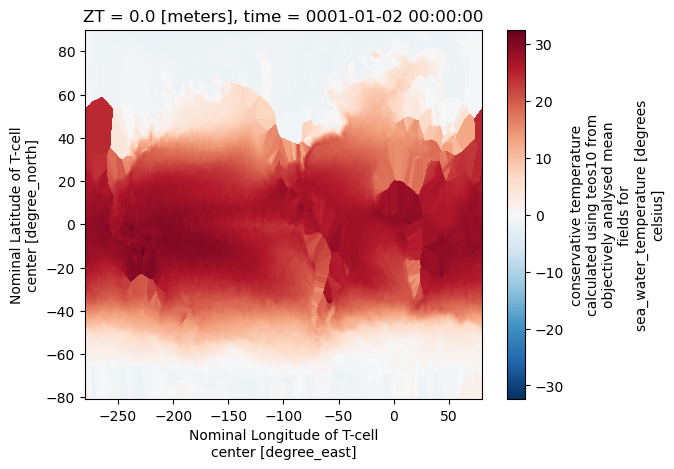

In [35]:
SST_obs.plot()

In [19]:
data = dict()
d = [ ds.search(variable='tos', frequency='1day', variable_cell_methods='.*time: mean.*') for ds in datastores ]
d = [ ds.to_dask() for ds in d if ds ] # avoid .to_dask() for empty datasets
data['tos'] = xr.concat(d, 'time')

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTi

In [20]:
data

{'tos': <xarray.Dataset> Size: 96GB
 Dimensions:  (time: 14600, yh: 1142, xh: 1440)
 Coordinates:
   * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
   * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
   * time     (time) object 117kB 1949-01-01 12:00:00 ... 1988-12-31 12:00:00
 Data variables:
     tos      (time, yh, xh) float32 96GB dask.array<chunksize=(1, 144, 240), meta=np.ndarray>
 Attributes: (12/15)
     title:                                    ACCESS-OM3
     associated_files:                         areacello: access-om3.mom6.stat...
     grid_type:                                regular
     grid_tile:                                N/A
     intake_esm_vars:                          ['tos']
     intake_esm_attrs:file_id:                 access_om3_mom6_2d_tos_1day_mea...
     ...                                       ...
     intake_esm_attrs:variable_standard_name:  ['', '', '', '', 'sea_surface_t...
     intake_

In [21]:
# set date range
trange = slice(cftime.DatetimeNoLeap(1970, 1, 1, 0, 0, 0, 0),
               cftime.DatetimeNoLeap(1980, 1, 1, 0, 0, 0, 0))

In [27]:
SST_mean = data['tos']['tos'].sel(time=trange).groupby('time.month').mean('time').sel(month=1)#.mean('month')#.mean('time')

In [28]:
SST_mean

<xarray.DataArray 'tos' (yh: 1142, xh: 1440)> Size: 7MB
dask.array<getitem, shape=(1142, 1440), dtype=float32, chunksize=(144, 240), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
    month    int64 8B 1
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [30]:
SST_mean.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 12.22 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.DataArray 'tos' (yh: 1142, xh: 1440)> Size: 7MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
    month    int64 8B 1
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [40]:
SST_obs = SST_obs.cf.assign_coords( { 'yh': SST_mean['yh'], 'xh': SST_mean['xh'] })
SST_obs

<xarray.DataArray 'temp' (yh: 1142, xh: 1440)> Size: 13MB
[1644480 values with dtype=float64]
Coordinates:
    ZT       float64 8B 0.0
    time     object 8B 0001-01-02 00:00:00
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
    month    int64 8B 1
  * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
Attributes:
    long_name:  conservative temperature calculated using teos10 from objecti...
    units:      degrees celsius

In [41]:
SST_bias = SST_mean-SST_obs # BUG: should convert to the same sort of temperature (eg conservative temperature)

In [42]:
SST_bias

<xarray.DataArray (yh: 1142, xh: 1440)> Size: 13MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
    month    int64 8B 1
    ZT       float64 8B 0.0
    time     object 8B 0001-01-02 00:00:00
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

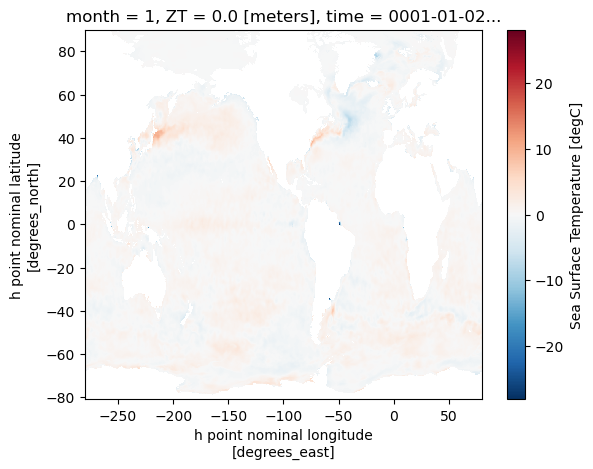

In [43]:
SST_bias.plot()

/g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_bias.png
   saved /g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/SST_bias.png


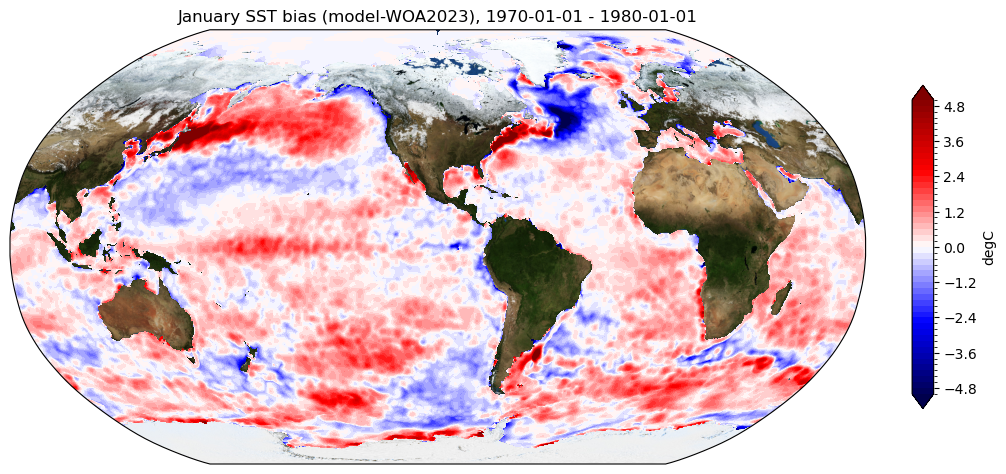

In [50]:
dat = SST_bias.cf.assign_coords( { "longitude": static['geolon'],
                                 "latitude": static['geolat'] })
fname = thisdir+'SST_bias.png'
print(fname)
if os.path.isfile(fname):
    print(f'   ---- skipping existing file {fname}')
else:
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    dat.plot.contourf(
        ax=ax,
        levels=51,
        vmin=-5,
        vmax=5,
        extend="both",
        cmap='seismic',
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": dat.attrs['units'], "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    )
    
    # Add blue marble land:
    ax.imshow(
        blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
    )
    
    plt.title(f"January SST bias (model-WOA2023), {trange.start.strftime('%Y-%m-%d')} - {trange.stop.strftime('%Y-%m-%d')}");
    
    plt.savefig(fname, dpi=150)
    print(f'   saved {fname}')


In [ ]:
# set date range

tstart = cftime.DatetimeNoLeap(1980, 1, 1, 0, 0, 0, 0)
tend = cftime.DatetimeNoLeap(1981, 1, 1, 0, 0, 0, 0)
timerange = slice(tstart, tend)
print('tstart =', tstart)
print('tend =', tend)

In [ ]:
for k, d in data.items():
    print(k)
    datall = d[k].sel(time=timerange)
    # datall.load()
    for t in datall.time.values:
        dat = datall.sel(time=t).cf.assign_coords( { "longitude": static['geolon'],
                                                    "latitude": static['geolat'] })
        fname = thisdir+k+'_'+dat.attrs['long_name'].replace(' ', '_').replace('/', '_')+'_'+t.strftime('%Y-%m-%d')+'.png'
        if os.path.isfile(fname):
            print(f'   ---- skipping existing file {fname}')
        else:
            fig = plt.figure(figsize=(12, 6))
            ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
            dat.plot.contourf(
                ax=ax,
                levels=33,
                vmin=0,
                vmax=1,
                extend="max",
                cmap=cm.cm.thermal,
                transform=ccrs.PlateCarree(),
                cbar_kwargs={"label": dat.attrs['units'], "fraction": 0.03, "aspect": 15, "shrink": 0.7},
            )
            
            # Add blue marble land:
            ax.imshow(
                blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
            )
            
            plt.title(dat.attrs['long_name']+' '+t.strftime('%Y-%m-%d'));

            try:
                plt.savefig(fname, dpi=150)
                print(f'   saved {fname}')
            except FileNotFoundError:
                print(f'*** FileNotFoundError when saving {fname}')
            # break
    # break

In [ ]:
! module load ffmpeg
! ffmpeg -r 30 -pattern_type glob -i 'speed_Sea_Surface_Speed_*.png' -c:v libx264 -vf "pad=trunc((iw+1)/2)*2:trunc((ih+1)/2)*2:0:0:white,crop=w=1506:h=692:x=219:y=92" -preset veryslow -tune animation -crf 25 -pix_fmt yuv420p -r 30 Sea_Surface_Speed5.mp4

In [ ]:
datall

In [ ]:
static['geolon']

In [ ]:
datall.sel(time=t)

In [ ]:
speed['speed'].isel(time=-1)

In [ ]:
dask.array.rechunk(datall, chunks='auto')

In [ ]:
datall

In [ ]:
datall.cf

In [ ]:
datall.cf.assign_coords(
        { "longitude": static['geolon'],
         "latitude": static['geolat'] }
    )

In [ ]:
speed.speed.isel(time=-1).cf

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

speed.speed.isel(time=-1).cf.assign_coords({ "longitude": static['geolon'],
                                             "latitude": static['geolat'] }
                                        ).plot.contourf(
    ax=ax,
    # x="longitude",
    # y="latitude",
    levels=33,
    vmin=0,
    vmax=1,
    extend="max",
    cmap=cm.cm.thermal,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"fraction": 0.03, "aspect": 15, "shrink": 0.7},
)

# Add blue marble land:
ax.imshow(
    blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
)

plt.title(speed.speed.attrs['long_name']);

In [ ]:
# fields = ['tosga', 'thetaoga', 'tos', 'sosga', 'soga', 'sos', 'SSH']#, 'KE', 'sss_global', 'volo', 'masso',]
fields = [ # from ncdump -h ctrl_run_25km_0.5/archive/output009/access-om3.mom6.scalar.1day.snap.1962.nc | grep double
    'soga',
    'thetaoga',
    'tosga',
    'sosga',
    'total_salt_Flux_Added',
    'total_salt_Flux_In',
    'total_salt_flux',
    'net_fresh_water_global_adjustment',
    'salt_flux_global_restoring_adjustment',
    'total_wfo',
    'total_evs',
    'total_fsitherm',
    'total_precip',
    'total_prsn',
    'total_lprec',
    'total_ficeberg',
    'total_friver',
    'total_net_massout',
    'total_net_massin',
]
data = dict()
for k in fields:
    print(k)
    # d = [ ds.search(variable=k).to_dataset_dict(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for ds in datastores ]
    try:
        d = [ ds.search(variable=k) for ds in datastores ]
        d = [ ds.to_dask() for ds in d if ds ] # avoid .to_dask() for empty datasets
    except ValueError:
        try:
            d = [ ds.search(variable=k, frequency='1mon', variable_cell_methods='.*time: mean.*') for ds in datastores ]
            d = [ ds.to_dask() for ds in d if ds ] # avoid .to_dask() for empty datasets
        except:
            try:
                d = [ ds.search(variable=k, variable_cell_methods='.*time: mean.*') for ds in datastores ]
                d = [ ds.to_dask() for ds in d if ds ] # avoid .to_dask() for empty datasets
            except:
                try:
                    d = [ ds.search(variable=k, variable_cell_methods='.*time: point.*') for ds in datastores ]
                    d = [ ds.to_dask() for ds in d if ds ] # avoid .to_dask() for empty datasets
                except:
                    try:
                        d = [ ds.search(variable=k, variable_cell_methods='.*time: min.*') for ds in datastores ]
                        d = [ ds.to_dask() for ds in d if ds ] # avoid .to_dask() for empty datasets
                    except:
                        try:
                            d = [ ds.search(variable=k, variable_cell_methods='.*time: max.*') for ds in datastores ]
                            d = [ ds.to_dask() for ds in d if ds ] # avoid .to_dask() for empty datasets
                        except:
                            print(f'{k} failed')
                            continue
    if d:
        data[k] = xr.concat(d, 'time')
    else:
        print(f'no data for {k}')
data

In [ ]:
data.keys()

In [ ]:
for k, d in data.items():
    print(k)
    dat = d[k]
    fname = thisdir+k+'_'+dat.attrs['long_name'].replace(' ', '_')+'.png'
    if os.path.isfile(fname):
        print(f'---- skipping existing file {fname}')
    else:
        if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
            dat = grid.average(dat, ['X', 'Y', 'Z'])
        elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
            dat = grid.average(dat, ['X', 'Y'])
        dat.load()
        if int((dat.time[1]-dat.time[0]).values/1e9/60/60/24) == 1:
            label = 'daily'
        else:
            label = 'monthly mean' # possible BUG: plausible guess
        plt.figure(figsize=(10,5))
        dat.plot(label=label)
        dat.cf.resample(time='1YE').mean('time').plot(label='annual mean')
        # dat.cf.rolling(time=12, center=True).mean('time').plot()
        # dat.cf.rolling(time='1YE', center=True).mean('time').plot()
        plt.title(k+': '+dat.attrs['long_name'])#+' ['+dat.attrs['units']+']')
        plt.legend()
        try:
            plt.savefig(fname, dpi=150)
            print(f'saved {fname}')
        except FileNotFoundError:
            print(f'*** FileNotFoundError when saving {fname}')
    # break

In [ ]:
dat.attrs['long_name'].replace(' ', '_')

In [ ]:
fields_mean = ['tosga', 'thetaoga', 'tos', 'sosga', 'soga', 'sos', 'sss_global', 'SSH', 'volo', 'masso',]# 'KE']
data_mean = { k: datastore.search(variable=k, 
                                  # frequency='1mon', 
                                  # variable_cell_methods='.*time: mean.*'
                                 ).to_dataset_dict(
    xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for k in fields_mean }
data_mean = { k: list(v.values())[0] for k, v in data_mean.items() if v } # drop any empty datasets
data_mean

In [ ]:
fields_mean = ['thetaoga', 'tos', 'soga', 'sos', 'sss_global', 'SSH', 'volo', 'masso',]# 'KE']
data_mean = { k: datastore.search(variable=k, 
                                  frequency='1mon', 
                                  # variable_cell_methods='.*time: mean.*'
                                 ).to_dataset_dict(
    xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for k in fields_mean }
data_mean = { k: list(v.values())[0] for k, v in data_mean.items() if v } # drop any empty datasets
data_mean

In [ ]:
fields_min = [ 'SSH_min', 'mlotst_min','uh', 'vh' ]
data_min = { k: datastore.search(variable=k, 
                                 frequency='1mon', 
                                 variable_cell_methods='.*time: min.*'
                                ).to_dataset_dict(
    xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for k in fields_min }
data_min = { k: list(v.values())[0] for k, v in data_min.items() if v } # drop any empty datasets
data_min

In [ ]:
fields_max = [ 'SSH_max', 'mlotst_max', 'uh', 'vh' ]
data_max = { k: datastore.search(
    variable=k, 
    frequency='1mon', 
    variable_cell_methods='.*time: max.*'
).to_dataset_dict(
    xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for k in fields_max }
data_max = { k: list(v.values())[0] for k, v in data_max.items() if v } # drop any empty datasets
data_max

In [ ]:
for k, d in data_mean.items():
    dat = d[k]
    if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = grid.average(dat, ['X', 'Y', 'Z'])
    elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = grid.average(dat, ['X', 'Y'])
    dat.load()
    if int((dat.time[1]-dat.time[0]).values/1e9/60/60/24) == 1:
        label = 'daily'
    else:
        label = 'monthly mean' # BUG: wild guess
    plt.figure(figsize=(10,5))
    dat.plot(label=label)
    dat.cf.resample(time='1YE').mean('time').plot(label='annual mean')
    # dat.cf.rolling(time=12, center=True).mean('time').plot()
    # dat.cf.rolling(time='1YE', center=True).mean('time').plot()
    plt.title(k)
    plt.legend()
    # break

In [ ]:
for k, d in data_min.items():
    dat = d[k]
    if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = dat.cf.min(dim=['latitude', 'longitude', 'depth'])
    elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = dat.cf.min(dim=['latitude', 'longitude'])
    dat.load()
    plt.figure(figsize=(10,5))
    dat.plot()
    dat.cf.rolling(time=12, center=True).mean('time').plot()
    plt.title(k)

In [ ]:
for k, d in data_max.items():
    dat = d[k]
    if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = dat.cf.max(dim=['latitude', 'longitude', 'depth'])
    elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = dat.cf.max(dim=['latitude', 'longitude'])
    dat.load()
    plt.figure(figsize=(10,5))
    dat.plot()
    dat.cf.rolling(time=12, center=True).mean('time').plot()
    plt.title(k)